In [188]:
%matplotlib notebook

import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from trajectories import simulate, simulate_rotation, get_view_vector, std_from_r, trajectory, simulate_c
from metric import rmse

from filterpy.kalman import KalmanFilter, UnscentedKalmanFilter as UKF, ExtendedKalmanFilter as EKF
from filterpy.common import Q_discrete_white_noise
import pickle

In [189]:
def np_from_traj(trajectory):
    positions = []
    rotations = []
    for item in trajectory.collection:
        positions.append(item.T)
        rotations.append(item.Re)
    return np.array(positions), np.array(rotations)

def np_from_traj_camera(trajectory):
    positions = []
    rotations = []
    accs = []
    for item in trajectory.collection:
        positions.append(item.T)
        rotations.append(item.Re)
        accs.append(item.imu_acc)
    return np.array(positions), np.array(rotations), np.array(accs)

In [190]:
with open('data/zed_trajectory.pkl', 'rb') as f:
    zed_data = pickle.load(f)

with open('data/gt_trajectory.pkl', 'rb') as f:
    gt_data = pickle.load(f)

with open('data/ms_trajectory.pkl', 'rb') as f:
    ms_data = pickle.load(f)

In [55]:
gt_traj, gt_rot = np_from_traj(gt_data)
zed_traj, zed_rot, zed_acc = np_from_traj_camera(zed_data)
ms_traj, ms_rot = np_from_traj(ms_data)


In [25]:
kf = KalmanFilter(dim_x=6, dim_z=3)
dt = 1
kf.x = [ms_traj[0][0], ms_traj[0][1], ms_traj[0][2], 0., 0., 0.]
# my_filter.x = [0., 0., 0., 0., 0., 0.]

# x, y, z, x', y', z',
kf.F = np.array([
    [1., 0, 0., dt, 0, 0],
    [0., 1., 0, 0, dt, 0],
    [0., 0., 1., 0., 0, dt],
    [0., 0., 0., 1., 0., 0],
    [0., 0., 0., 0., 1., 0],
    [0., 0., 0, 0, 0, 1.]
])    # state transition matrix

kf.H = np.array([
    [1., 0., 0., 0, 0, 0],
    [0., 1., 0., 0, 0, 0],
    [0., 0., 1., 0, 0, 0],
])    # Measurement function
# my_filter.P                  # covariance matrix
kf.R = 1000#std_from_r(0.001, radius)                      # state uncertainty
kf.Q = Q_discrete_white_noise(3, dt, 10, 2) # process uncertainty


In [26]:
filtered = []
for i in range(1, len(ms_traj)):
    kf.predict()
    kf.update(zed_traj[i])
    kf.update(ms_traj[i])
    
    x = kf.x
    filtered.append(x)
filtered = np.array(filtered)

In [27]:
print(rmse(gt_traj[1:], filtered[:, :3]))
print(rmse(gt_traj[1:], ms_traj[1:]))
print(rmse(gt_traj[1:], zed_traj[1:]))

(array([0.05881128, 0.07188524, 0.07260657]), 0.06776769252487053)
(array([0.07924591, 0.07977831, 0.08035992]), 0.07979471286004437)
(array([0.07961556, 0.08079631, 0.08208857]), 0.08083347769631637)


# rotation

In [37]:
kf = KalmanFilter(dim_x=6, dim_z=3)
dt = 1
kf.x = [ms_rot[0][0], ms_rot[0][1], ms_rot[0][2], 0., 0., 0.]
# my_filter.x = [0., 0., 0., 0., 0., 0.]

# x, y, z, x', y', z',
kf.F = np.array([
    [1., 0, 0., dt, 0, 0],
    [0., 1., 0, 0, dt, 0],
    [0., 0., 1., 0., 0, dt],
    [0., 0., 0., 1., 0., 0],
    [0., 0., 0., 0., 1., 0],
    [0., 0., 0, 0, 0, 1.]
])    # state transition matrix

kf.H = np.array([
    [1., 0., 0., 0, 0, 0],
    [0., 1., 0., 0, 0, 0],
    [0., 0., 1., 0, 0, 0],
])    # Measurement function
# my_filter.P                  # covariance matrix
kf.R = 1000#std_from_r(0.001, radius)                      # state uncertainty
kf.Q = Q_discrete_white_noise(3, dt, 10, 2) # process uncertainty


In [38]:
filtered = []
for i in range(1, len(ms_traj)):
    kf.predict()
#     kf.update(zed_rot[i])
    kf.update(ms_rot[i])
    
    x = kf.x
    filtered.append(x)
filtered = np.array(filtered)

# Kalman FIlters diff

In [191]:
gt_traj, gt_rot = np_from_traj(gt_data)
zed_traj, zed_rot, zed_acc = np_from_traj_camera(zed_data)
ms_traj, ms_rot = np_from_traj(ms_data)


In [196]:
kf = KalmanFilter(dim_x=9, dim_z=6)
dt = 1
# kf.x = [ms_traj[0][0], ms_traj[0][1], ms_traj[0][2], 0., 0., 0., 0., 0., 0.]
kf.x = [0., 0., 0., 0., 0., 0., 0., 0., 0.]

# x, y, z, x', y', z',
kf.F = np.array([
    [1., 0., 0., dt, 0., 0., dt**2 / 2, 0., 0.],
    [0., 1., 0., 0., dt, 0., 0., dt**2 / 2, 0.],
    [0., 0., 1., 0., 0., dt, 0., 0., dt**2 / 2],
    [0., 0., 0., 1., 0., 0., dt, 0., 0.],
    [0., 0., 0., 0., 1., 0., 0., dt, 0.],
    [0., 0., 0., 0., 0., 1., 0., 0., dt],
    [0., 0., 0., 0., 0., 0., 1., 0., 0.],
    [0., 0., 0., 0., 0., 0., 0., 1., 0.],
    [0., 0., 0., 0., 0., 0., 0., 0., 1.],
])    # state transition matrix

kf.H = np.array([
    [1., 0., 0., 0, 0, 0, 0, 0, 0],
    [0., 1., 0., 0, 0, 0, 0, 0, 0],
    [0., 0., 1., 0, 0, 0, 0, 0, 0],
    [0., 0., 0., 0, 0, 0, 1, 0, 0],
    [0., 0., 0., 0, 0, 0, 0, 1, 0],
    [0., 0., 0., 0, 0, 0, 0, 0, 1],
])    # Measurement function
# my_filter.P                  # covariance matrix
kf.R = 1#std_from_r(0.001, radius)                      # state uncertainty
kf.Q = Q_discrete_white_noise(3, dt, 0.1, 3) # process uncertainty


In [197]:
filtered = []
for i in range(len(ms_traj)):
    kf.predict()
#     kf.update(zed_traj[i])
    y = [ms_traj[i][0], ms_traj[i][1], ms_traj[i][2], zed_acc[i][0], zed_acc[i][2], zed_acc[i][2]]
    kf.update(y)
    
    x = kf.x
    filtered.append(x)
filtered = np.array(filtered)

In [198]:
print(rmse(gt_traj[:], filtered[:, :3]))
print(rmse(gt_traj[1:], ms_traj[1:]))
print(rmse(gt_traj[1:], zed_traj[1:]))

(array([0.16409167, 0.16344349, 0.163265  ]), 0.16360004979580586)
(array([0.16019588, 0.16036477, 0.16062485]), 0.16039516924763028)
(array([0.0007979 , 0.00079968, 0.00079576]), 0.0007977809036112318)


In [63]:
zed_rot.shape

(3, 3)

<IPython.core.display.Javascript object>


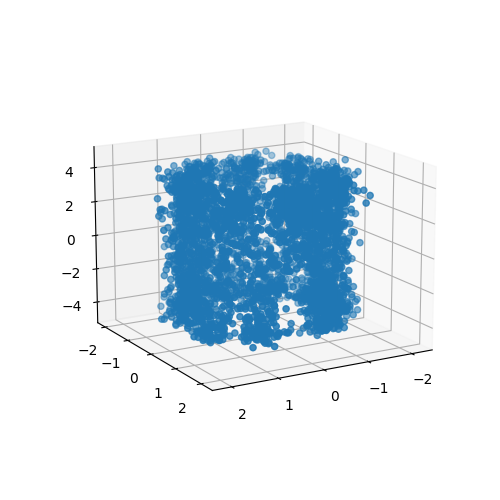

In [199]:
# filtered = np.array(filtered)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(filtered[:, 0], filtered[:, 1], filtered[:, 2])
# ax.scatter(gt_traj[:, 0], gt_traj[:, 1], gt_traj[:, 2])
# ax.scatter(zed_traj[:, 0], zed_traj[:, 1], zed_traj[:, 2])
# ax.scatter(ms_traj[:, 0], ms_traj[:, 1], ms_traj[:, 2])

# ax.scatter(final[:, 0], final[:, 1], final[:, 2])
# ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2])
# ax.scatter(positions2[:, 0], positions2[:, 1], positions2[:, 2])

# Real Data

In [200]:
import pickle

In [201]:
with open("/home/nrogovoy/Downloads/mt_data.pkl", 'rb') as f:
    mt_data = pickle.load(f)3

with open('/home/nrogovoy/Downloads/a04fbb6d-9f4d-4c7c-b8fa-8c1b8bdd1497/export/camera_data.pkl', 'rb') as f:
    camera_data = pickle.load(f)

In [255]:
mt_traj, mt_rot = np_from_traj(mt_data)
cam_traj, cam_rot, cam_acc = np_from_traj_camera(camera_data)
mt_traj = mt_traj[:-1]
cam_traj = cam_traj[:-1]
cam_acc = cam_acc[:-1]

In [256]:
from akaze_calibrator import compute_pose_matrix

In [258]:
Re, T = compute_pose_matrix(cam_traj, mt_traj)
cam_traj_t = (cam_traj @ (Re.T) + T)
cam_acc_t = cam_acc @ Re.T


<IPython.core.display.Javascript object>


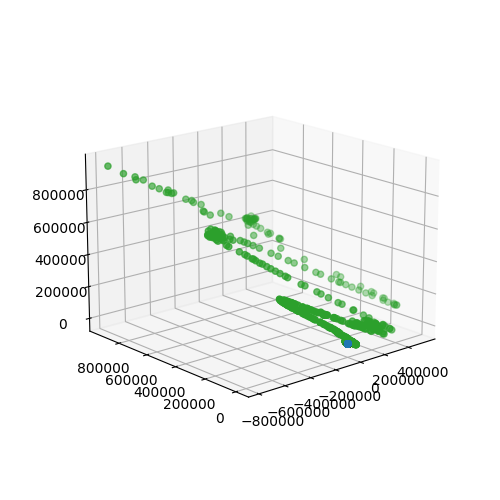

In [340]:
# filtered = np.array(filtered)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mt_traj[:, 0], mt_traj[:, 1], mt_traj[:, 2])
# ax.scatter(mt_traj[:100, 0], mt_traj[:100, 1], mt_traj[:100, 2])
# ax.scatter(cam_traj[:, 0], cam_traj[:, 1], cam_traj[:, 2])
# ax.scatter(cam_traj[:100, 0], cam_traj[:100, 1], cam_traj[:100, 2])
ax.scatter(tranlated_data[:, 0], tranlated_data[:, 1], tranlated_data[:, 2])
# ax.scatter(tranlated_data[:100, 0], tranlated_data[:100, 1], tranlated_data[:100, 2])
ax.scatter(filtered[:, 0], filtered[:, 1], filtered[:, 2])
# ax.scatter(tranlated_data[:100, 0], tranlated_data[:100, 1], tranlated_data[:100, 2])


In [382]:
kf = KalmanFilter(dim_x=9, dim_z=6)
dt = 1 / 15
kf.x = [ms_traj[0][0], ms_traj[0][1], ms_traj[0][2], 0., 0., 0., 0., 0., 0.]
# kf.x = [0., 0., 0., 0., 0., 0., 0., 0., 0.]

# x, y, z, x', y', z',
kf.F = np.array([
    [1., 0., 0., dt, 0., 0., dt**2 / 2, 0., 0.],
    [0., 1., 0., 0., dt, 0., 0., dt**2 / 2, 0.],
    [0., 0., 1., 0., 0., dt, 0., 0., dt**2 / 2],
    [0., 0., 0., 1., 0., 0., dt, 0., 0.],
    [0., 0., 0., 0., 1., 0., 0., dt, 0.],
    [0., 0., 0., 0., 0., 1., 0., 0., dt],
    [0., 0., 0., 0., 0., 0., 1., 0., 0.],
    [0., 0., 0., 0., 0., 0., 0., 1., 0.],
    [0., 0., 0., 0., 0., 0., 0., 0., 1.],
])    # state transition matrix

kf.H = np.array([
    [1., 0., 0., 0, 0, 0, 0, 0, 0],
    [0., 1., 0., 0, 0, 0, 0, 0, 0],
    [0., 0., 1., 0, 0, 0, 0, 0, 0],
    [0., 0., 0., 0, 0, 0, 1, 0, 0],
    [0., 0., 0., 0, 0, 0, 0, 1, 0],
    [0., 0., 0., 0, 0, 0, 0, 0, 1],
])    # Measurement function
# my_filter.P                  # covariance matrix
kf.R = 1#std_from_r(0.001, radius)                      # state uncertainty
kf.Q = Q_discrete_white_noise(3, dt, 0.1, 3) # process uncertainty


In [392]:
filtered = []
for i in range(1, len(mt_traj)):
    kf.predict()
#     kf.update(zed_traj[i])
    y = [mt_traj[i][0], mt_traj[i][1], mt_traj[i][2], cam_acc[i][0], cam_acc[i][2], cam_acc[i][2]]
#     y = [cam_acc[i][0], cam_acc[i][2], cam_acc[i][2]]
    kf.update(y)
#     y1 = [cam_traj[i][0], cam_traj[i][1], cam_traj[i][2]]
#     kf.update(y1)
    x = kf.x
    filtered.append(x)
filtered = np.array(filtered)

In [393]:
print(rmse(filtered[:, :3], tranlated_data[:-1]))
print(rmse(mt_traj, tranlated_data))

(array([37.08548298, 19.2617271 , 18.06654036]), 24.804583482813864)
(array([33.38473539, 18.42099181, 16.32870451]), 22.711477239358544)


In [366]:
with open('/home/nrogovoy/Downloads/ce6d2684-e1aa-4bc3-9ee0-0adbe54359e1/export/camera_data.pkl', 'rb') as f:
    data_6a = pickle.load(f)

In [329]:
anton_traj, anton_rot, anton_acc = np_from_traj_camera(data_6a)

In [330]:
kf = KalmanFilter(dim_x=9, dim_z=6)
dt = 1
# kf.x = [ms_traj[0][0], ms_traj[0][1], ms_traj[0][2], 0., 0., 0., 0., 0., 0.]
kf.x = [0., 0., 0., 0., 0., 0., 0., 0., 0.]

# x, y, z, x', y', z',
kf.F = np.array([
    [1., 0., 0., dt, 0., 0., dt**2 / 2, 0., 0.],
    [0., 1., 0., 0., dt, 0., 0., dt**2 / 2, 0.],
    [0., 0., 1., 0., 0., dt, 0., 0., dt**2 / 2],
    [0., 0., 0., 1., 0., 0., dt, 0., 0.],
    [0., 0., 0., 0., 1., 0., 0., dt, 0.],
    [0., 0., 0., 0., 0., 1., 0., 0., dt],
    [0., 0., 0., 0., 0., 0., 1., 0., 0.],
    [0., 0., 0., 0., 0., 0., 0., 1., 0.],
    [0., 0., 0., 0., 0., 0., 0., 0., 1.],
])    # state transition matrix

kf.H = np.array([
    [1., 0., 0., 0, 0, 0, 0, 0, 0],
    [0., 1., 0., 0, 0, 0, 0, 0, 0],
    [0., 0., 1., 0, 0, 0, 0, 0, 0],
    [0., 0., 0., 0, 0, 0, 1, 0, 0],
    [0., 0., 0., 0, 0, 0, 0, 1, 0],
    [0., 0., 0., 0, 0, 0, 0, 0, 1],
])    # Measurement function
# my_filter.P                  # covariance matrix
kf.R = 1#std_from_r(0.001, radius)                      # state uncertainty
kf.Q = Q_discrete_white_noise(3, dt, 0.1, 3) # process uncertainty


In [331]:
filtered = []
for i in range(1, len(anton_traj)):
    kf.predict()
#     kf.update(zed_traj[i])
    y = [anton_traj[i][0], anton_traj[i][1], anton_traj[i][2], anton_acc[i][0], anton_acc[i][2], anton_acc[i][2]]
    kf.update(y)
#     y1 = [cam_traj[i][0], cam_traj[i][1], cam_traj[i][2]]
#     kf.update(y1)
    x = kf.x
    filtered.append(x)
filtered = np.array(filtered)

<IPython.core.display.Javascript object>


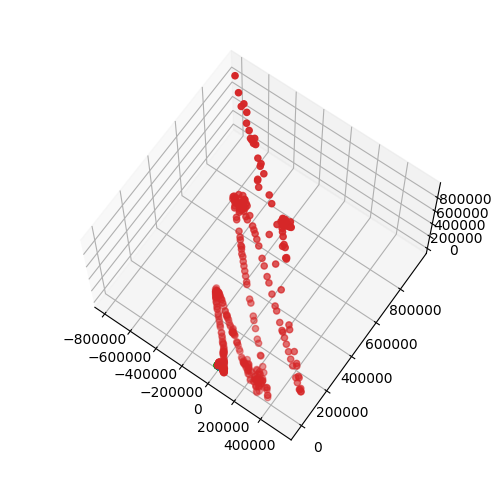

In [338]:
# filtered = np.array(filtered)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(anton_traj[110:340, 0], anton_traj[110:340, 1], anton_traj[110:340, 2])
ax.scatter(anton_traj[340:400, 0], anton_traj[340:400, 1], anton_traj[340:400, 2])
ax.scatter(anton_traj[400:, 0], anton_traj[400:, 1], anton_traj[400:, 2])
ax.scatter(filtered[:, 0], filtered[:, 1], filtered[:, 2])

# ax.scatter(mt_traj[:100, 0], mt_traj[:100, 1], mt_traj[:100, 2])
# ax.scatter(cam_traj[:, 0], cam_traj[:, 1], cam_traj[:, 2])
# ax.scatter(cam_traj[:100, 0], cam_traj[:100, 1], cam_traj[:100, 2])
# ax.scatter(tranlated_data[:, 0], tranlated_data[:, 1], tranlated_data[:, 2])
# ax.scatter(tranlated_data[:100, 0], tranlated_data[:100, 1], tranlated_data[:100, 2])
# ax.scatter(filtered[:, 0], filtered[:, 1], filtered[:, 2])
# ax.scatter(tranlated_data[:100, 0], tranlated_data[:100, 1], tranlated_data[:100, 2])


In [319]:
with open('/home/nrogovoy/Downloads/gathered_data.pkl', 'rb') as f:
    gathered_data = pickle.load(f)

In [324]:
gathered_data.collection[1]